## 프로젝트 : 주식 예측에 도전해 보자

삼성전자 주식 시세 예측

#### STEP 1 : 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#005930 => 삼성전자 
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

# Time Series 생성
ts = df["Close"]
ts.head()

<class 'pandas.core.frame.DataFrame'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

csv read시 index_col옵션을 주어 index화하면 컬럼을 선택하지 않아도 dataframe에 나옴. parse_dates = True / date변환 여부 

#### STEP 2 : 각종 전처리 수행

전처리 수행전 plot 확인

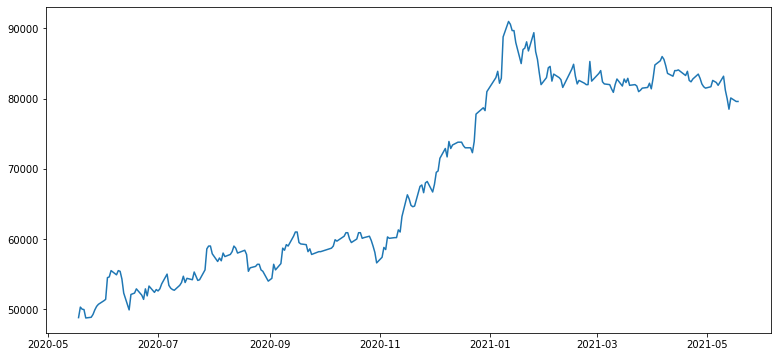

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

결측치 유무 확인

In [3]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

결측치 처리

Series([], Name: Close, dtype: float64)


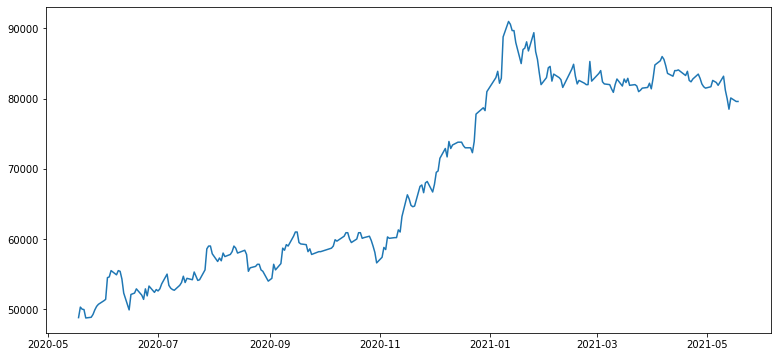

In [4]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

로그변환 

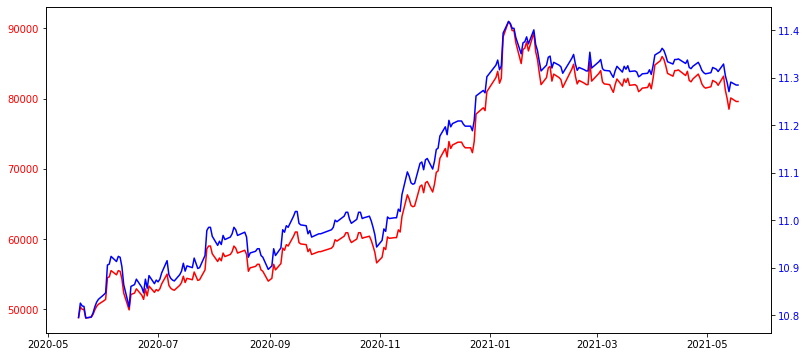

In [5]:
# 로그 변환 시도 
ts_log = np.log(ts)

fig, ax1 = plt.subplots()
ax1.plot(ts, color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax2 = ax1.twinx()
ax2.plot(ts_log, color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
plt.show()

Series([], Name: Close, dtype: float64)


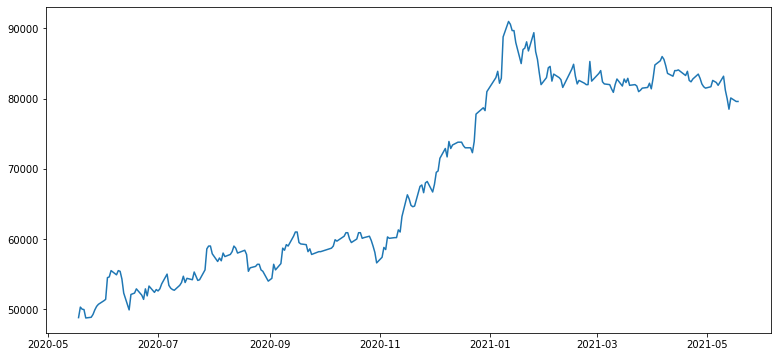

In [6]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

로그변환 

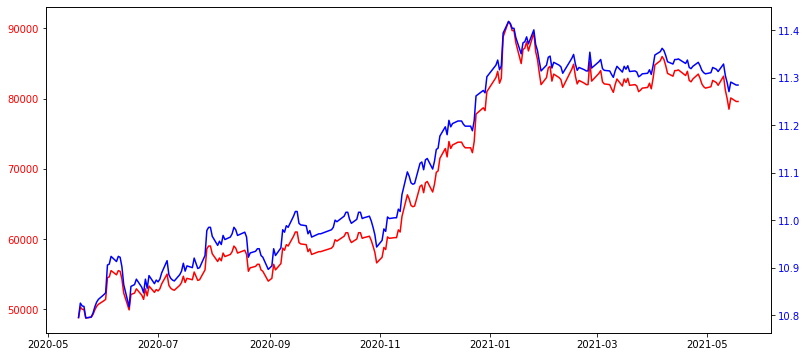

In [7]:
# 로그 변환 시도 
ts_log = np.log(ts)

fig, ax1 = plt.subplots()
ax1.plot(ts, color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax2 = ax1.twinx()
ax2.plot(ts_log, color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
plt.show()

#### STEP 3 : 시계열 안정성 분석

In [8]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='RollingbStd')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

시계열 데이터가 Stational하는지 검증하는 ADF함수

In [9]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

seasonal_decompose 시계열 데이터분해 <br>
statsmodels.tsa.seasonal.season_decompse( x, model='additive|multiplicative', filt=None, period=None, two_sided=True, extrapolate_trend=0)
<br>filt:계절 성분 필터링하기 위한 필터 계수 <br>
period : 기간, 시계열 데이터가 pandas객체가 아니거나 x의 인덱스에 빈도가 없는 경우 사용<br>
two_sided : 필터링에 사용되는 이동평균 방법 True인경우 필터를 사용하여 중심 이동 평균 계산<br>
extraploate_trend : 0으로 설정/'freq'로 설정하는 방법 사용 상세내용 확인 필요<br>

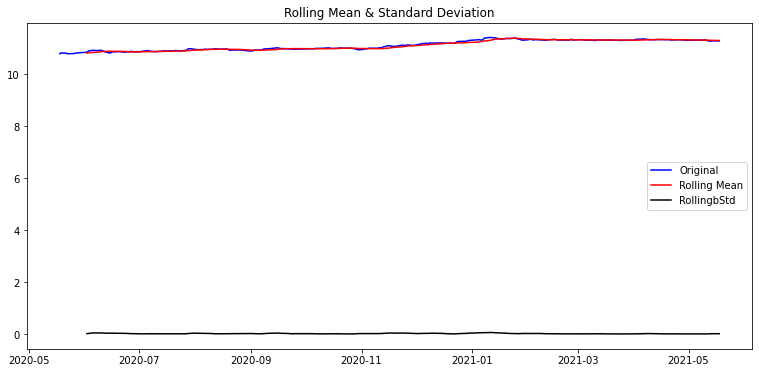

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


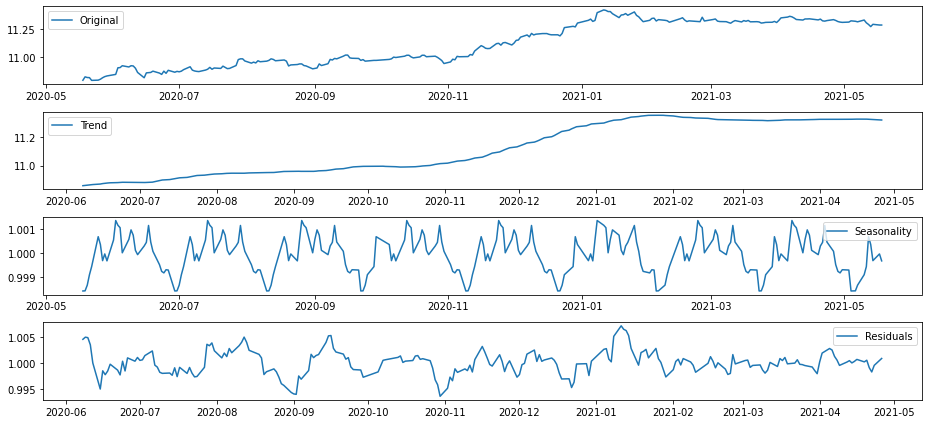

In [10]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Residual 안정성 검증

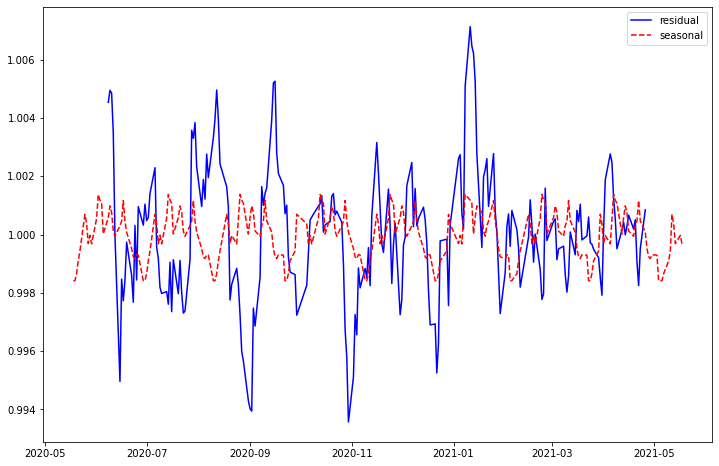

In [11]:
residual.dropna(inplace=True)

## 1. Automatic detection of elements to be shown in the legend
## 1-1. label
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

## labels: A list of labels to show next to the artists. 
ax.plot(residual, 'b-', label='residual')
ax.plot(seasonal, 'r--', label='seasonal') 
ax.legend()
plt.show()

In [12]:
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


#### STEP 4 : 학습, 테스트 데이터셋 생성

학습, 테스트 데이터셋 분리
추후 타 종목 검색을 위해서 함수로 설정

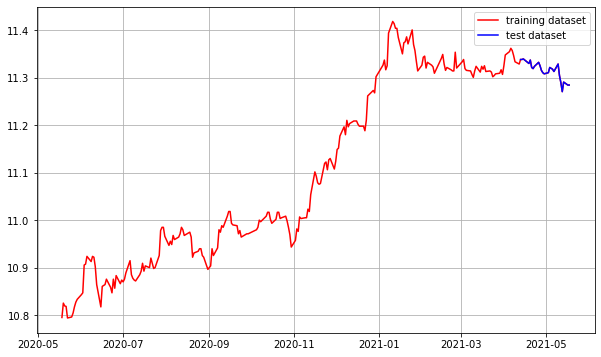

In [13]:
def train_data_split(param_ts, ratio):
    train_data, test_data = param_ts[:int(len(param_ts)*ratio)], param_ts[int(len(param_ts)*ratio):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    return train_data, test_data
train_data, test_data = train_data_split(ts_log, 0.9)

#### STEP 5 : 적정 ARIMA 모수 찾기

ACF, PACF 그려보기 -> p,q 구하기<br>
차분 안정성 확인 -> d 구하기
<br> 타 종목을 위하여 함수 처리

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


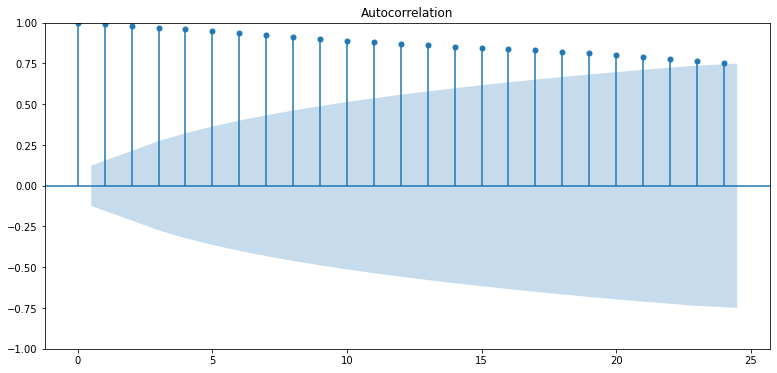

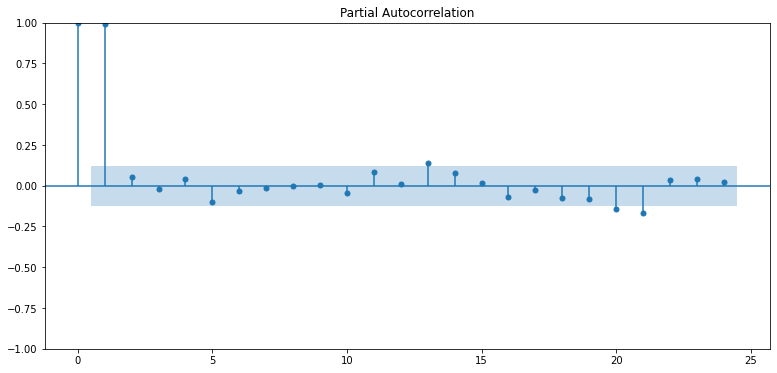

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(param_ts):
    plot_acf(param_ts)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(param_ts)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()
plot_acf_pacf(ts_log)

차분 안정성 확인 -> d 구하기 

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


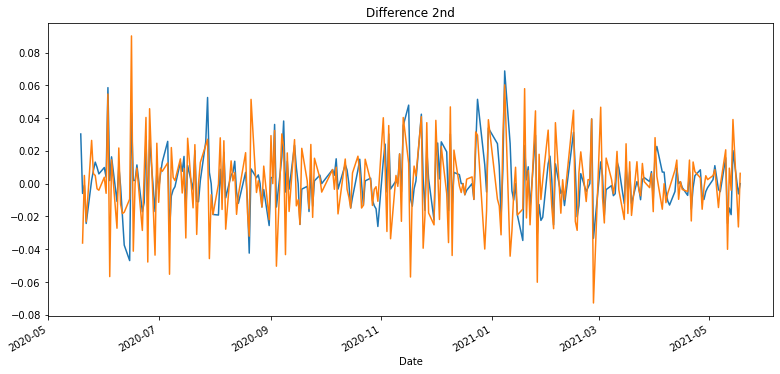

In [15]:
def diff_1_2_adf(param_ts):
    # 1차 차분 구하기
    diff_1 = param_ts.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')
   
    augmented_dickey_fuller_test(diff_1)

    # 혹시 필요한 경우 2차 차분 구하기
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')

    augmented_dickey_fuller_test(diff_2)
    
diff_1_2_adf(ts_log)

#### STEP 6 : ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련

In [16]:
from statsmodels.tsa.arima.model import ARIMA

def build_model(param_train_data):
    # Build Model
    model = ARIMA(train_data, order=(2, 0, 1))  
    fitted_m = model.fit() 

    print(fitted_m.summary())
    
    return fitted_m

fitted_m = build_model(train_data)    

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Fri, 11 Nov 2022   AIC                          -1156.722
Time:                        12:35:48   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

모델 테스트 및 플로팅

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


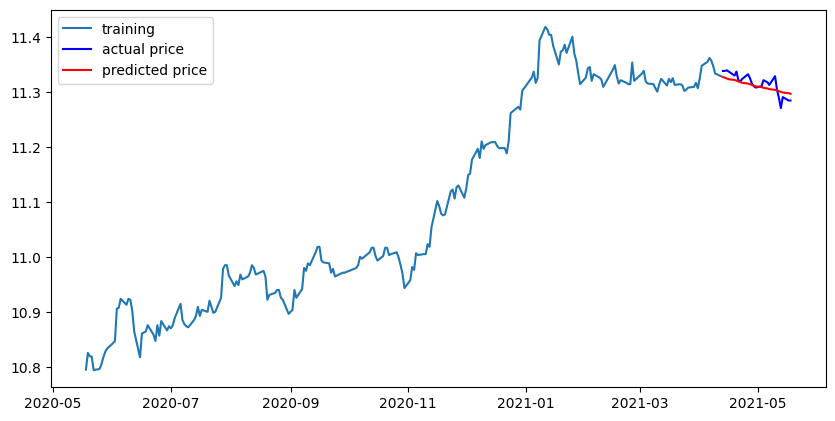

In [19]:
def forecast_plot(param_test_data, param_model):
    # Forecast : 결과가 fc에 담깁니다. 
    fc = param_model.forecast(len(param_test_data), alpha=0.05)  # 95% conf
    fc = np.array(fc)
    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    return fc, fc_series

fc, fc_series = forecast_plot(test_data, fitted_m)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

최종 예측 모델 정확도 측정(MAPE)

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


### STEP 7 : 다른 주식 종목 예측해 보기

#### STEP1 데이터 불러오기

In [21]:
#005930 => 삼성전자 
dataset_filepath = os.getenv('HOME')+'/aiffel/Exp4/data/035420naver.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True).sort_values(by=['Date'], axis=0)
print(type(df))
df.head()

# Time Series 생성
ts = df["Close"]
ts.tail()

<class 'pandas.core.frame.DataFrame'>


Date
2022-11-07    169000
2022-11-08    177500
2022-11-09    180000
2022-11-10    176000
2022-11-11    193500
Name: Close, dtype: int64

#### STEP 2 : 각종 전처리 수행

전처리 수행전 plot 확인

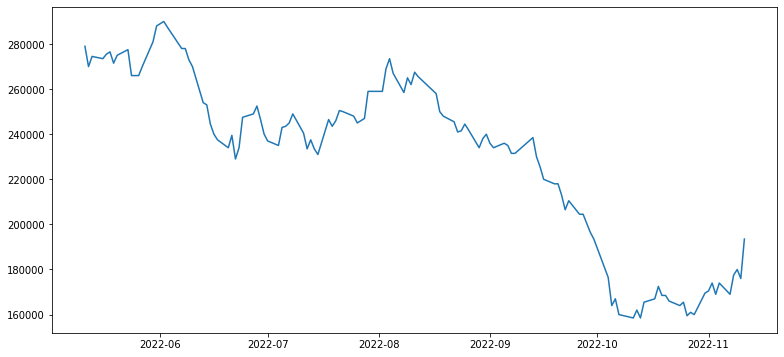

In [22]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)
plt.show()

결측치 처리<br>
timeseries.interpolate 

Series([], Name: Close, dtype: int64)


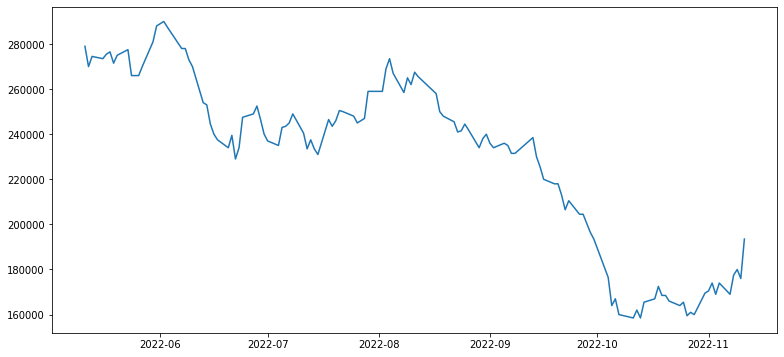

In [23]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)
plt.show()

로그변환 

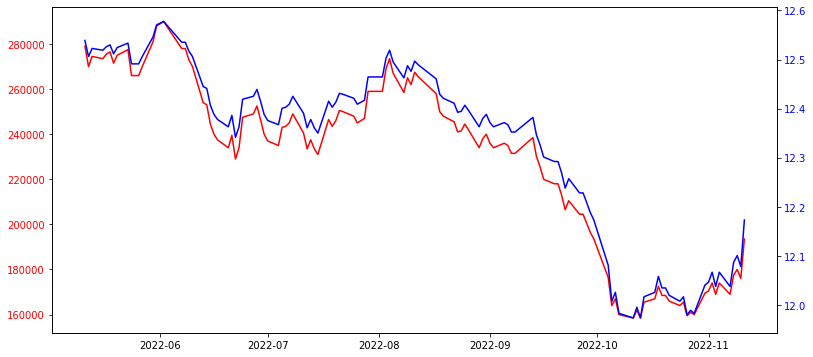

In [24]:
# 로그 변환 시도 
ts_log = np.log(ts)

fig, ax1 = plt.subplots()
ax1.plot(ts, color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax2 = ax1.twinx()
ax2.plot(ts_log, color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
plt.show()

#### STEP 3 : 시계열 안정성 분석

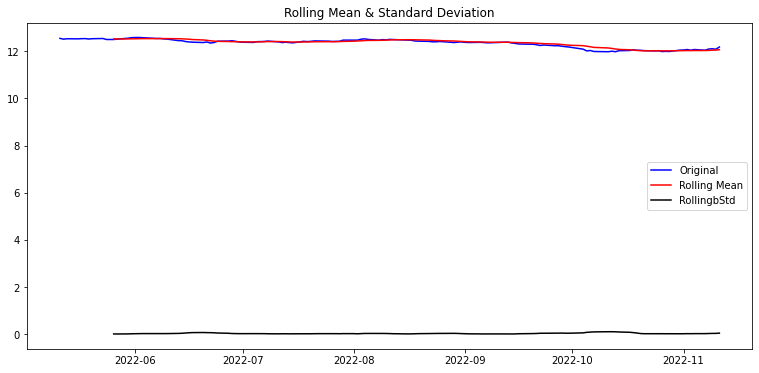

Results of Dickey-Fuller Test:
Test Statistic                  -1.307914
p-value                          0.625544
#Lags Used                       3.000000
Number of Observations Used    122.000000
Critical Value (1%)             -3.485122
Critical Value (5%)             -2.885538
Critical Value (10%)            -2.579569
dtype: float64


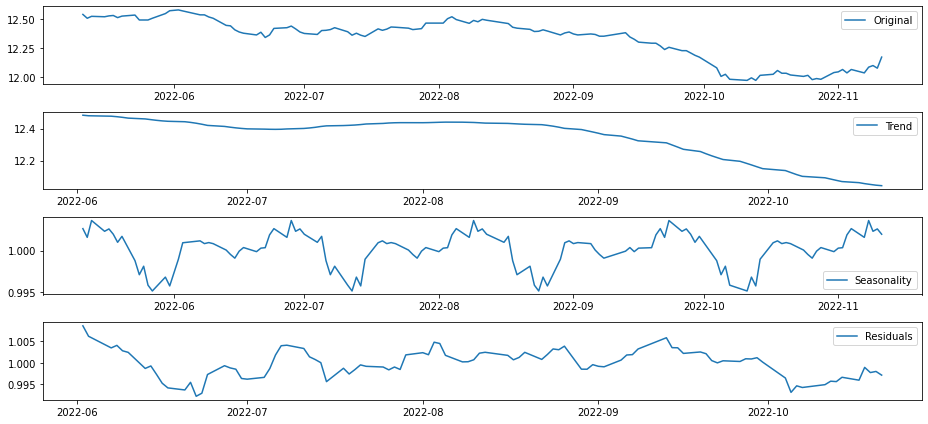

In [25]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

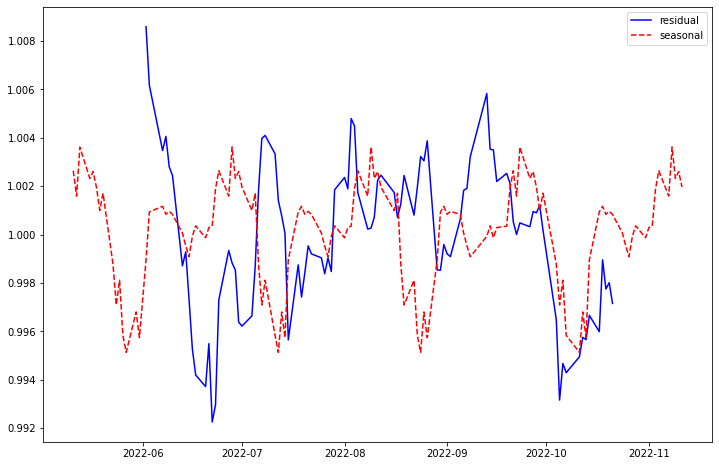

In [26]:
residual.dropna(inplace=True)

## 1. Automatic detection of elements to be shown in the legend
## 1-1. label
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

## labels: A list of labels to show next to the artists. 
ax.plot(residual, 'b-', label='residual')
ax.plot(seasonal, 'r--', label='seasonal') 
ax.legend()
plt.show()

In [27]:
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                 -3.416437
p-value                         0.010411
#Lags Used                      0.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


#### STEP 4 : 학습, 테스트 데이터셋 생성

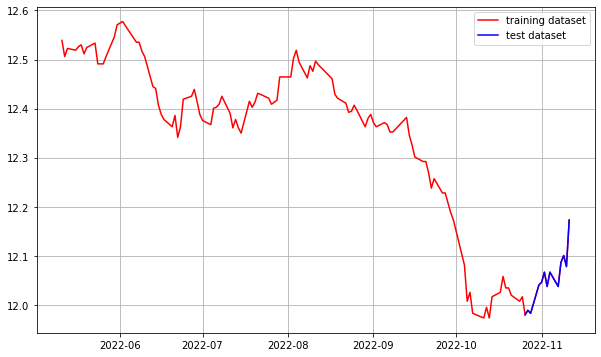

In [28]:
train_data, test_data = train_data_split(ts_log, 0.9)

#### STEP 5 : 적정 ARIMA 모수 찾기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


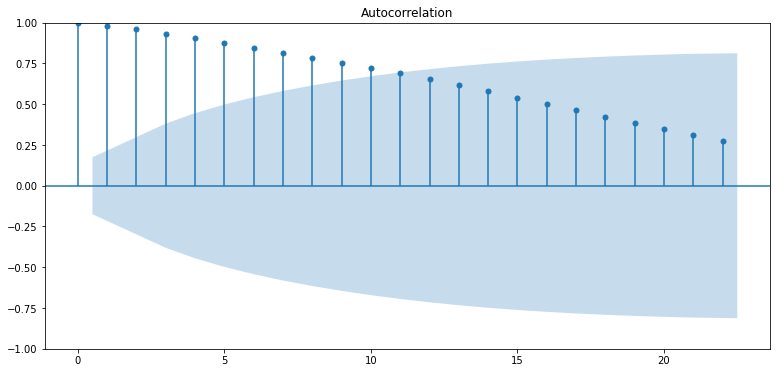

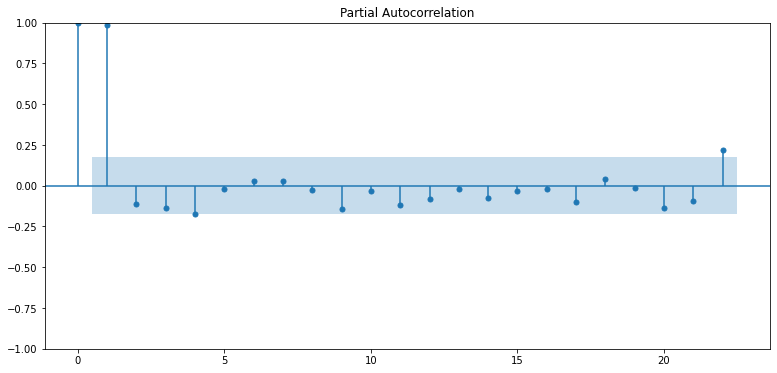

In [29]:
plot_acf_pacf(ts_log)

차분 안정성 확인 -> d 구하기

차분을 구하여 ADF를 통해서 시계열의 Stationary한지 여부 검증

2차 차분은 1차 차분을 가지고 계산

Results of Dickey-Fuller Test:
Test Statistic                  -4.566219
p-value                          0.000149
#Lags Used                       2.000000
Number of Observations Used    122.000000
Critical Value (1%)             -3.485122
Critical Value (5%)             -2.885538
Critical Value (10%)            -2.579569
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.548606e+00
p-value                        8.968060e-09
#Lags Used                     7.000000e+00
Number of Observations Used    1.160000e+02
Critical Value (1%)           -3.488022e+00
Critical Value (5%)           -2.886797e+00
Critical Value (10%)          -2.580241e+00
dtype: float64
Date
2022-05-12   -0.032790
2022-05-13    0.016529
2022-05-16   -0.003650
2022-05-17    0.007286
2022-05-18    0.003623
                ...   
2022-11-07   -0.029157
2022-11-08    0.049072
2022-11-09    0.013986
2022-11-10   -0.022473
2022-11-11    0.094794
Name: Close, Length: 125, dtype: float64


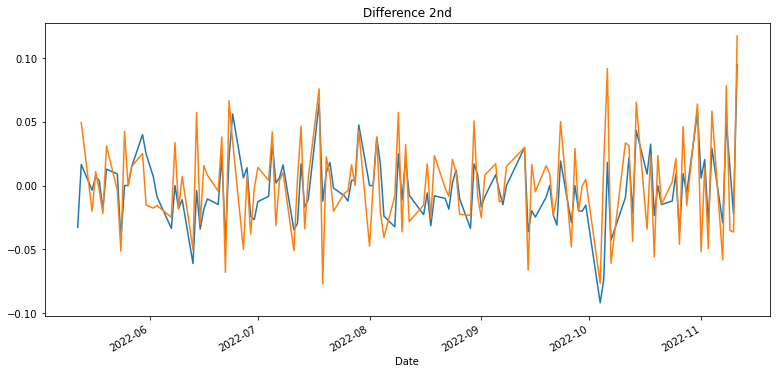

In [41]:
def diff_1_2_adf_2(param_ts):
    # 1차 차분 구하기
    diff_1 = param_ts.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')
   
    augmented_dickey_fuller_test(diff_1)

    # 혹시 필요한 경우 2차 차분 구하기
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')

    augmented_dickey_fuller_test(diff_2)
    print(diff_1)
    
diff_1_2_adf_2(ts_log)

STEP 6 : ARIMA 모델 훈련과 테스트

In [43]:
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())
    


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  113
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 255.642
Date:                Fri, 11 Nov 2022   AIC                           -501.284
Time:                        15:41:41   BIC                           -487.647
Sample:                             0   HQIC                          -495.750
                                - 113                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3034      0.220     55.862      0.000      11.872      12.735
ar.L1          0.2844      0.186      1.532      0.126      -0.079       0.648
ar.L2          0.7056      0.190      3.718      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


모델 테스트 및 플로팅

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


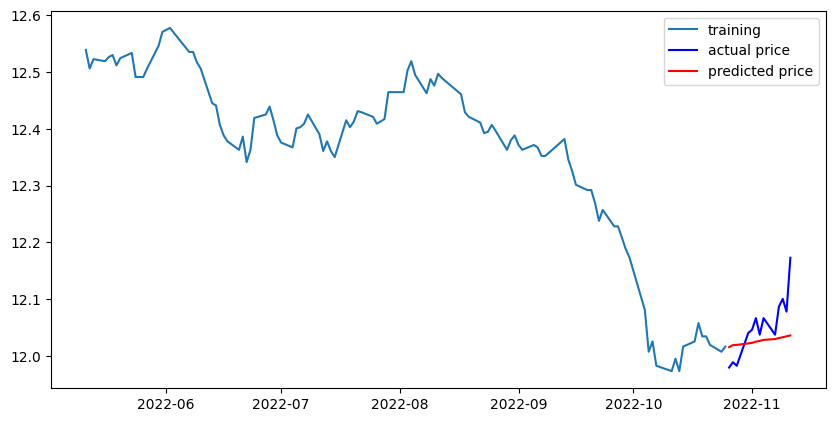

In [46]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

최종 예측 모델 정확도 측정(MAPE)

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  85611871.63666072
MAE:  7230.336313925733
RMSE:  9252.668352246325
MAPE: 4.09%


## 회고

- 시계열 모델링 순서 <br>
 1. 시계열 데이터가 Stationary한지 여부를 데이터 시각화 등을 통하여 확인 <br>
 2. 결측치 확인하여 결측치 보간( ts.interpolate(method='time'))<br>
 3. 로그변환( ts_log = np.log(ts)) log1p를 사용하지 않고 log를 사용/ log1p와 비교<br>
 4. 시계열 안정성(Stationary) 분석    <br>
 5. 학습데이터 생성<br>
 6. 차분안정성을 확인하여 p-value의값이 높은 경우 Stationary하지 않으므로 시계열 데이터 정상화 <br>
 7. ARIMA모델을 생성하고 훈련<br>
 8. 예측을 수행<br>
 9. 최종 예측 모델 정확도 측정 (MAPE)<br>

- ARIMA모델
 . 자기회귀 모델과 이동평균 모델의 통합모델 <br> 
 . 시계열 데이터에서 Trend와 Seasonality, Residual로 분해해서 Residual이 안정적인 예측력을 갖도록 모델을 만듬<br>
 . AR과 MA간 적정수준 찾아감<br>
 . ARIMA모델의 모수 p, q,d <br>
 . p: 자기회귀모형(AR)의 시차 <br>
 . d: 차분누적(I)횟수<br>
 . q: 이동평균 모형(MA)의 시차<br>
   => 적절한 모수 p, d, q를 선택하는 대표적인 방법 <br>
   ACF(Autocorrelation Function) 와 PACF(Partial Autocorrelation Function)이 있음 <br>
    AutoCorrelation은 자기상관계수와 같음<br>
   ACF -> 시차에 따른 관측치들 사이 관련성 측정 함수 <br>
   PACF -> 특정 두 관측치가 얼마나 관련이 있는지 나타내는 척도<br>
   
  